In [700]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


fontdictval={'fontsize': 11,'fontname': 'Times New Roman',"color":"black"}
#Función para dar formato a la gráfica
def grafica(titulo,ejex,ejey):
    #=======================Elaboracion ejes==================
    plt.title(titulo, fontdict=fontdictval)
    plt.ylabel(ejey, fontdict=fontdictval)
    plt.xlabel(ejex, fontdict=fontdictval)
    #==========================Enmallado=================================
    plt.tick_params(direction='out', length=5, width=0.75, grid_alpha=0.3)
    plt.minorticks_on()
    plt.grid(True)
    plt.grid(visible=True, which='major', color='grey', linestyle='-')
    plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', alpha=0.5)
    plt.legend(loc='best')
    #=====================================================================
    plt.show()

In [701]:
# Read the CSV file
df = pd.read_csv('./data_coquito/tm1_datos_torre_meteo.csv')

# Combine the year, month, day, hour, and minute columns into a single datetime column
df['timestamp'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute']])

# Set the timezone to UTC-5
df['timestamp'] = df['timestamp'].dt.tz_localize('America/Bogota')

# Set the timestamp as the index
df.set_index('timestamp', inplace=True)

#Filtrar el año 2012
df=df[df.index.year==2012]
# Drop the original year, month, day, hour, and minute columns if no longer needed
df.drop(columns=['year', 'month', 'day', 'hour', 'minute'], inplace=True)

df

,velocidad_viento@98m,direccion_viento@98m,temperatura,humedad_relativa,presion
timestamp,,,,,
2012-01-01 00:00:00-05:00,9.96,78.1,25.9,96.1,1013.048
2012-01-01 01:00:00-05:00,9.85,79.0,25.9,96.1,1013.664
2012-01-01 02:00:00-05:00,9.86,78.5,25.8,96.2,1014.074
2012-01-01 03:00:00-05:00,9.87,78.5,25.8,96.1,1014.405
2012-01-01 04:00:00-05:00,9.92,79.2,25.7,96.3,1013.714
...,...,...,...,...,...
2012-12-31 19:00:00-05:00,9.76,70.1,26.6,95.5,1012.401
2012-12-31 20:00:00-05:00,9.74,68.1,26.5,95.7,1011.724
2012-12-31 21:00:00-05:00,9.96,67.1,26.5,95.8,1011.459


In [702]:
from scipy.stats import weibull_min

# Fit the Weibull distribution
shape, loc, scale = weibull_min.fit(df['velocidad_viento@98m'], floc=0)  # floc=0 forces the location parameter to be 0

# Print the fitted parameters
print(f"Shape parameter (k): {shape}")
print(f"Scale parameter (c): {scale}")

Shape parameter (k): 4.4784590116199965
Scale parameter (c): 8.584498072853332


In [703]:
velocidad_viento = df['velocidad_viento@98m']
# Crear los bins
num_bins = 12
bin_edges = np.linspace(velocidad_viento.min(), velocidad_viento.max(), num_bins + 1)

# Asignar cada dato a un bin
bin_labels = pd.cut(velocidad_viento, bins=bin_edges, include_lowest=True)

# Calcular el porcentaje de datos en cada bin
bin_counts = bin_labels.value_counts(sort=False)
bin_percentages = (bin_counts / len(velocidad_viento))

# Obtener el mínimo y máximo de cada bin
bin_min = bin_edges[:-1]  # Borde inferior de cada bin
bin_max = bin_edges[1:]   # Borde superior de cada bin


bin_stats = pd.DataFrame({
    "Wind speed min (m/s)": bin_min,
    "Wind speed max (m/s)": bin_max,
    "Count": bin_counts.values,
    "Percentage ()": bin_percentages.values
})

bin_stats["Hours/year"] = round(bin_stats["Percentage ()"] * 8760,2)

bin_stats[['Wind speed min (m/s)', 'Wind speed max (m/s)','Hours/year']]
velocidad_viento_promedio = velocidad_viento.mean()


In [704]:
rho=1.15
bin_stats["Power density (W/m^2)"] = 0.5 * rho * ((bin_stats["Wind speed min (m/s)"] + bin_stats["Wind speed max (m/s)"]) / 2)**3
bin_stats["Anual output (kWh/m^2)"] = bin_stats["Power density (W/m^2)"] * bin_stats["Hours/year"] / 1000
total_output = bin_stats["Anual output (kWh/m^2)"].sum()
print(f"Total output by bins: {total_output:.2f} kWh/m^2")
bin_stats[['Wind speed min (m/s)', 'Wind speed max (m/s)','Hours/year','Power density (W/m^2)','Anual output (kWh/m^2)']]

#Calculamos el promedio de cada bin de acuerdo a Rayleigh distribution
bin_stats["Rayleigh probability (%)"] = (1- np.exp((-np.pi/4)*(bin_stats["Wind speed max (m/s)"]/velocidad_viento_promedio)**2)) - (1- np.exp((-np.pi/4)*(bin_stats["Wind speed min (m/s)"]/velocidad_viento_promedio)**2))
bin_stats["Hours/year Rayleigh"] = round(bin_stats["Rayleigh probability (%)"] * 8760,2)
bin_stats ["Anual output Rayleigh (kWh/m^2)"] = bin_stats["Power density (W/m^2)"] * bin_stats["Hours/year Rayleigh"] / 1000
total_output_rayleigh = bin_stats["Anual output Rayleigh (kWh/m^2)"].sum()
print(f"Total output by Rayleigh distribution: {total_output_rayleigh:.2f} kWh/m^2")
print(f"Porcentaje de diferencia entre la observada y la estimada por Rayleigh: {((total_output-total_output_rayleigh)/total_output)*100:.2f}%")
bin_stats


Total output by bins: 2925.56 kWh/m^2
Total output by Rayleigh distribution: 2193.62 kWh/m^2
Porcentaje de diferencia entre la observada y la estimada por Rayleigh: 25.02%


,Wind speed min (m/s),Wind speed max (m/s),Count,Percentage (),Hours/year,Power density (W/m^2),Anual output (kWh/m^2),Rayleigh probability (%),Hours/year Rayleigh,Anual output Rayleigh (kWh/m^2)
0,0.240000,1.283333,42,0.004781,41.89,0.254075,0.010643,0.020106,176.13,0.044750
1,1.283333,2.326667,127,0.014458,126.65,3.381423,0.428257,0.046047,403.37,1.363964
2,2.326667,3.370000,235,0.026753,234.36,13.287408,3.114037,0.068299,598.30,7.949856
3,3.370000,4.413333,337,0.038365,336.08,33.890248,11.389835,0.085308,747.30,25.326182
4,4.413333,5.456667,408,0.046448,406.89,69.108158,28.119418,0.096186,842.59,58.229843
5,5.456667,6.500000,792,0.090164,789.84,122.859353,97.039231,0.100765,882.70,108.447951
6,6.500000,7.543333,1334,0.151867,1330.36,199.062049,264.824188,0.099543,872.00,173.582107
7,7.543333,8.586667,1939,0.220742,1933.70,301.634463,583.270561,0.093530,819.33,247.138164
8,8.586667,9.630000,1845,0.210041,1839.96,434.494809,799.453069,0.084043,736.21,319.879423
9,9.630000,10.673333,1266,0.144126,1262.54,601.561304,759.495209,0.072485,634.97,381.973381


In [705]:
power_eq_10=(0.5*rho*((((6/np.pi)**(1/3))*velocidad_viento_promedio)**3)/1000)*8760
print(f"Total output by power equation: {power_eq_10:.2f} kWh/m^2")
print(f"Porcentaje de diferencia entre la observada y la estimada por eq 10: {((power_eq_10-total_output)/total_output)*100:.2f}%")


Total output by power equation: 4629.68 kWh/m^2
Porcentaje de diferencia entre la observada y la estimada por eq 10: 58.25%


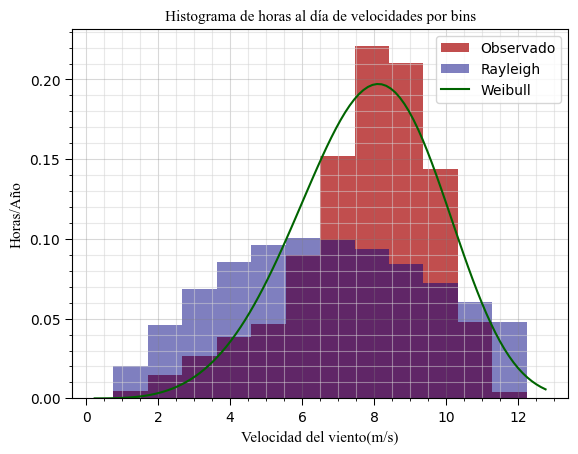

In [706]:
plt.hist((bin_stats["Wind speed min (m/s)"]+bin_stats["Wind speed max (m/s)"])/2, weights=bin_stats["Percentage ()"], bins=num_bins, alpha=0.8, label='Observado',color="firebrick")
plt.hist((bin_stats["Wind speed min (m/s)"]+bin_stats["Wind speed max (m/s)"])/2, weights=bin_stats["Rayleigh probability (%)"], bins=num_bins, alpha=0.5, label='Rayleigh',color="navy")

shape, loc, scale = weibull_min.fit(df["velocidad_viento@98m"], floc=0)  # floc=0 forces the location parameter to be 0
x = np.linspace(df["velocidad_viento@98m"].min(),df["velocidad_viento@98m"].max(), 100)
pdf = weibull_min.pdf(x, shape, loc=loc, scale=scale)
plt.plot(x,pdf,color="darkgreen", label='Weibull')
grafica("Histograma de horas al día de velocidades por bins","Velocidad del viento(m/s)","Horas/Año")

C:\Users\tigre\AppData\Local\Temp\ipykernel_66136\4255578614.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df2["V-avg. (m/s)"][0]=np.nan
C:\Users\tigre\AppData\Local\Temp\ipykernel_66136\4255578614.py:6: SettingWithCopyWarning: 
A valu

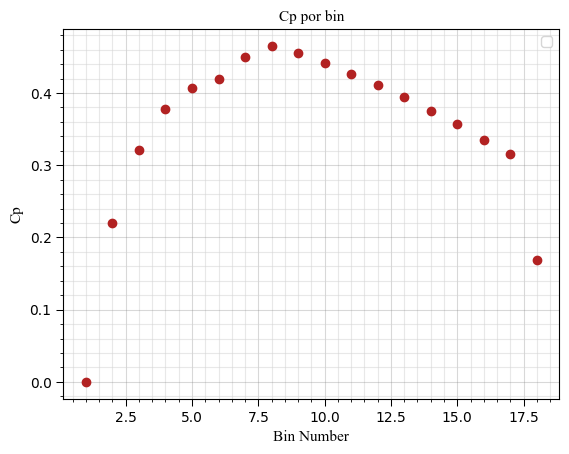

,Bin Num.,V-avg. (m/s),P-out (kW),P,C_p
0,1,NaN,0,NaN,0.000000
1,2,6.50,175,793.739092,0.220475
2,3,7.00,318,991.360978,0.320771
3,4,7.50,460,1219.330649,0.377256
4,5,8.00,603,1479.815804,0.407483
5,6,8.50,745,1774.984141,0.419722
6,7,9.00,949,2107.003361,0.450403
7,8,9.50,1153,2478.041161,0.465287
8,9,10.00,1316,2890.265241,0.455322
9,10,10.50,1479,3345.843300,0.442041


In [707]:


df2=pd.read_csv('./data_coquito/cd_data.csv',delimiter=";")


area=(np.pi*40**2)

df2["V-avg. (m/s)"][0]=np.nan
df2["V-avg. (m/s)"]=df2["V-avg. (m/s)"].astype(float)
df2["P"]=0.5*rho*df2["V-avg. (m/s)"]**3/1000*area
df2["C_p"]=df2["P-out (kW)"]/df2["P"]
df2["C_p"][0]=0

plt.plot(df2["Bin Num."],df2["C_p"],color="firebrick",marker="o",linestyle=" ")
grafica("Cp por bin","Bin Number","Cp")

df2

In [708]:
v_avg=9.6
df2["Max speed"]=df2["V-avg. (m/s)"]+0.25
df2["Max speed"][0]=6.25
df2["Max speed"][17]=22.5
df2["CFD"]= (1- np.exp((-np.pi/4)*(df2["Max speed"]/v_avg)**2))

#Defino el porcentaje como el cfd de la fila anterior menos la fila actual
df2["Porcentaje"]=df2["CFD"].diff()

df2["Porcentaje"][0]=df2["CFD"][0]

df2["Tiempo"]=df2["Porcentaje"]*8760

df2["Energia (MWh)"]=df2["P-out (kW)"]*df2["Tiempo"]/1E3

energia_total=df2["Energia (MWh)"].sum()

capacidad=energia_total/(2.5*8760)

capacidad

C:\Users\tigre\AppData\Local\Temp\ipykernel_66136\3296410046.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df2["Max speed"][0]=6.25
C:\Users\tigre\AppData\Local\Temp\ipykernel_66136\3296410046.py:3: SettingWithCopyWarning: 
A value is 

np.float64(0.43343748974200547)

In [709]:
0.5*1.1*2.6*0.26*28.89**3+1383*9.81*28.89*0.01

12884.608191994203

In [711]:
12.88/(1/20.29*0.72*43500*0.02889)

0.2888208985772873

In [712]:
60.3**2

3636.0899999999997

In [714]:
0.5*0.4*115*0.03*225**3+0.5*(231e3*9.81)**2/(0.4*225*3636.09)

15705649.427767877

In [727]:
15705649.427767877*0.86/295

45785.96104366228

In [728]:
700/220

3.1818181818181817

In [723]:
15.7*0.86

13.501999999999999

In [733]:
(3.82*61.11+0.1404*61.11**2+0.006532*61.11**3)*3.18/295

24.237309664147052

In [734]:
(45.77-24.23)/45.77

0.47061393926152506